In [1]:
# specify to reload any packages that are changed
# helps with not having to restart the kernel each time
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import copy
import corner 
#Pointing to my desired local versions of scarlet
# sys.path.insert(0,'/home/cw1074/newscarlet/scarlet2')
# sys.path.insert(0,'/home/cw1074/HSC/pulsars/scarlet')
import os
import scarlet
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping,AsinhPercentileNorm,show_scarlet2_scene,LinearPercentileNorm
import glob
import sep
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import numpyro.distributions as dist
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.wcs import WCS
from scarlet.source import StaticSource,MultiExtendedSource, StaticMultiExtendedSource
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import distrax
import optax
from tqdm.auto import tqdm
import pandas as pd
from numpyro.distributions import constraints
import cmasher as cmr
from scarlet2 import *
import scarlet2
import glob

# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

/curveball/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Provide name and position of source, desired bands, and location of image data.

In [3]:
# #List of all bands appearing in the imaging data 
# bandall=['G','I','R']#,'Y','Z']

# sources = np.loadtxt('/home/cw1074/HSC/HSCAGN/dwarf_agn_cosmos/hsc_agn_updated.txt',dtype=str,skiprows = 45,usecols = (10,1,2))

# row = sources[3]
# src=row[0]
# srcname = row[0]
# ra=float(row[1])
# dec=float(row[2])
# print(src,ra,dec)
# datadir='/scratch/gpfs/cw1074/HSCdata'
# imagedir = datadir+'/'+src
# if not os.path.isdir(imagedir):
#     os.mkdir(imagedir)
# plotdir = datadir+'/'+src+'/plots'
# if not os.path.isdir(plotdir):
#     os.mkdir(plotdir)

# coord_transient = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')


FileNotFoundError: /home/cw1074/HSC/HSCAGN/dwarf_agn_cosmos/hsc_agn_updated.txt not found.

In [4]:
ra, dec = 150.79702, 2.13888
coord_transient = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')

Define a function which stacks the images and performs source detection on the stack

In [5]:
def makeCatalog(observations, lvl=3, wave=True):
    normed_images = np.asarray([obs.data for obs in observations])
    interps = [scarlet.interpolation.interpolate_observation(obs, observations[0]) for obs in observations[:10]]
    interps = np.asarray(interps/np.sum(interps))
    detect_image = np.sum(interps,axis=(0,1))
    # Wavelet transform
    wave_detect = scarlet.Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect-bkg.globalback, 3, err=bkg.globalrms)
    background=[]
    bg_rms=[]
    for obs in observations:
        img = obs.data
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
            background.append(np.array([sep.Background(band).globalback for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
            background.append(sep.Background(img).globalback)
    return catalog, bg_rms, detect_image, background

For each band, obtain the science, weight and PSF images. Loop over each image and create scarlet1 and scarlet2 observation objects.

In [6]:
datadir='/pscratch/sd/e/eramey16/data/saved_curveball'
imagedir = datadir+'/'+'scarlet'

bandall=['G','I','R']
observations=[]
observations_sc2=[]
channels=[]
channels_sc2 =[]
times=[]
zps =[]
norms=[]
for band in bandall:
    imageout=[]
    psfs=[]
    imagetar = glob.glob(imagedir+'/warps-HSC-'+band+'*.tar')
    for fn in imagetar:
        taropen = tarfile.open(fn)
        taropen.extractall(imagedir)
        taropen.close()

    matchestar = glob.glob(imagedir+'/psf-warp-*-'+band+'-*.tar')
    for fn in matchestar:
        taropen = tarfile.open(fn)
        taropen.extractall(imagedir)
        taropen.close()
    images = glob.glob(imagedir+'/warps-HSC-'+band+'-*-pdr3_dud*/warp-*.fits')
    for fn in images:
        epochid = fn.split('/')[-1].split('-')[-1].rstrip('.fits')
        matches = glob.glob(imagedir+'/psf-*HSC-'+band+'*-'+epochid+'*.fits')    
        if len(matches)>0:
            imageout.append(fn)
            psfs.append(matches[0])

    for ind,(img,psf) in enumerate(zip(imageout[:10],psfs[:10])):
        obs_hdu = fits.open(img)
        try:
            mjd = Time(obs_hdu[0].header['DATE-AVG'],format='isot',scale='utc').mjd
        except KeyError:
            print('No time')
            continue
        data_hsc = obs_hdu[1].data.byteswap().newbyteorder()
        N1, N2 = data_hsc.shape
        data_hsc = data_hsc.reshape(1, N1, N2)
        weight_hsc = np.reciprocal(obs_hdu[3].data)#**2
        mask_hsc = obs_hdu[2].data
        mask_new = np.invert((mask_hsc==32)|(mask_hsc==64)|(mask_hsc==0)|(mask_hsc==2048))
        weight_hsc[mask_new] = 0
        weight_hsc[np.isnan(obs_hdu[1].data)] = 0
        if np.sum(weight_hsc==0)>0.01*weight_hsc.shape[-2]*weight_hsc.shape[-1]:
            print('Poor image, skipping')
            continue
        Nw1, Nw2 = weight_hsc.shape
        weight_hsc = weight_hsc.reshape(1, Nw1, Nw2)
        mask_hsc = mask_new.reshape(1, Nw1, Nw2)
        wcs_hsc = WCS(obs_hdu[1].header)
        channel = [band+str(ind)]
        channel_sc2 = (band, str(ind)) 
        channels.append(band+str(ind))
        channels_sc2.append(channel_sc2)
        psf_hsc0 = fits.open(psf)[0].data
        Np1, Np2 = psf_hsc0.shape
        p1,p2=psf_hsc0.shape
        print(channel, channel_sc2)
        
        if p1-37>0:
            psf_hsc0=psf_hsc0[int((p1-37)/2):-int((p1-37)/2),:]
        if p2-37>0:
            psf_hsc0=psf_hsc0[:,int((p2-37)/2):-int((p2-37)/2)]
        
        psf_hsc = scarlet.ImagePSF(psf_hsc0)
        r=1
        
        # Scarlet1 object
        obs_hsc = scarlet.Observation(data_hsc,
                wcs=wcs_hsc,
                psf=psf_hsc,
                channels=channel,
                weights=weight_hsc)
        observations.append(obs_hsc)
        
        # Time array
        times.append(mjd)
        # Scarlet2 object
        # Note: looks like you can give it the real PSF
        obs_sc2 = scarlet2.Observation(jnp.asarray(data_hsc), jnp.asarray(weight_hsc), psf=scarlet2.ArrayPSF(jnp.asarray([psf_hsc0,])),channels=[channel_sc2])#,wcs=wcs_hsc)
        observations_sc2.append(obs_sc2)
        norms.append(AsinhPercentileNorm(data_hsc,percentiles=[1,95]))
        print(mjd)


model_psf = scarlet.GaussianPSF(sigma=0.7)
model_frame = scarlet.Frame.from_observations(observations, coverage='intersection', model_psf=model_psf)
frame_psf_sc2 = scarlet2.GaussianPSF(0.7)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),observations_sc2[0].data.shape[-1],observations_sc2[0].data.shape[-2])), psf=frame_psf_sc2, channels=channels_sc2)


for obs in observations_sc2:
    obs.match(model_frame_sc2)

['G0'] ('G', '0')


I0000 00:00:1705001521.888960 1609767 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


57807.35709745949
Poor image, skipping
['G2'] ('G', '2')
57841.29475697338
['G3'] ('G', '3')
57817.451060405096
Poor image, skipping
['G5'] ('G', '5')
57159.25622549769
Poor image, skipping
['G7'] ('G', '7')
56979.549631626156
['G8'] ('G', '8')
57869.326779299765
['G9'] ('G', '9')
57841.27009508102
['I0'] ('I', '0')
56743.294679890045
['I1'] ('I', '1')
57809.442758425925
['I2'] ('I', '2')
57776.56211808449
Poor image, skipping
Poor image, skipping
['I5'] ('I', '5')
56743.35379711227
['I6'] ('I', '6')
56743.39071339121
['I7'] ('I', '7')
57039.40103238426
['I8'] ('I', '8')
57776.54373502315
['I9'] ('I', '9')
57869.23687446759
['R0'] ('R', '0')
57099.422940920136
Poor image, skipping
Poor image, skipping
['R3'] ('R', '3')
57099.42689563658
['R4'] ('R', '4')
56744.38056494213
['R5'] ('R', '5')
57837.262910300924
['R6'] ('R', '6')
57807.45958047454
['R7'] ('R', '7')
56744.36598971643
['R8'] ('R', '8')
57456.340578958334
['R9'] ('R', '9')
57866.25841951389


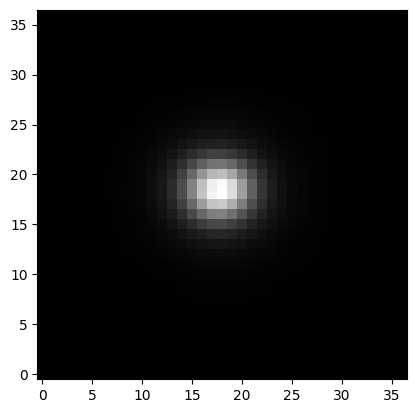

In [8]:
# Emily added
import matplotlib.pyplot as plt
plt.imshow(data_hsc[0])
channel_sc2
plt.imshow(psf_hsc0)

Run source detection to create a catalog of source positions. Subtract background from images.

In [9]:
lvl = 1 #???
wave = 1
#Obtain source catalog and background flux estimation from our makeCatalog function
catalog_single, bgsingle, detectsingle, globalback = makeCatalog(observations, lvl, wave)
obssinglearr=np.asarray(observations)
bgsinglearr=np.asfarray(bgsingle)
pixel = np.stack((catalog_single['y'], catalog_single['x']), axis=1)
ra_dec = [obs.get_sky_coord(pixel) for obs in obssinglearr][0]
normsingle=[]
for ind,(obs,obs2,bg,back) in enumerate(zip(observations,observations_sc2,bgsingle,globalback)):
    #obs.weights = np.ones(obs.shape) / (bg)[:, None, None]
    #Store norm based on observation data
    normsingle.append(LinearPercentileNorm(obs.data,percentiles=[0.1, 99.9]))

In [10]:
### Emily's stuff

observations[0]

### End Emily's stuff

Plot the first couple of images

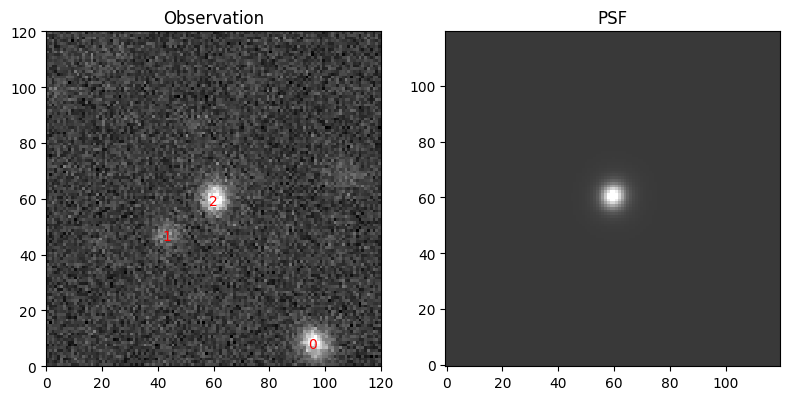

In [11]:
if np.asarray(ra_dec).shape==(2,):
    for ind,(obs, norm) in enumerate(zip(observations[:1], normsingle[:1])):
        scarlet.display.show_observation(obs, norm=norm, sky_coords=[ra_dec], show_psf=True)
else:    
    for ind,(obs, norm) in enumerate(zip(observations[:1], normsingle[:1])):
        scarlet.display.show_observation(obs, norm=norm, sky_coords=ra_dec, show_psf=True)
    

Create the PSF model and create the model frame based on the observations

In [12]:
model_psf_s = scarlet.GaussianPSF(sigma=0.7)
model_frame_s = scarlet.Frame.from_observations(observations, coverage='intersection', model_psf=model_psf_s)

In [13]:
ra_dec, ra_dec.shape

(array([[150.79535251,   2.1364838 ],
        [150.79779131,   2.1382788 ],
        [150.79699988,   2.1388738 ]]),
 (3, 2))

Create the sources: static sources for background sources and static+variable point source for the AGN and its host galaxy

In [14]:
sources = []
if np.asarray(ra_dec).shape==(2,):
    print('Only one source found, initializing in center')
    for ind,sky_coord in enumerate([ra_dec]):
        separ=[0]
        print('Initialization source',ind,'at',sky_coord)
        sources.append(scarlet.PointSource(model_frame_s,
                                sky_coord,
                                observations,
                                ))
        sources.append(scarlet.SingleExtendedSource(model_frame_s,
                            sky_coord,
                               observations,
                               thresh=0.01,
                               shifting=True,
                               resizing=True
                              ))
        indtransient=0
else:
    c2 = [SkyCoord(ra*u.deg,dec*u.deg,frame='icrs') for ra,dec in ra_dec]
    separ = [coord_transient.separation(c).arcsecond for c in c2]
    indtransient = np.argmin(separ)
    indgal = np.argmin(separ)
    for ind,sky_coord in enumerate(ra_dec):
        print('Initializing source',ind,'at',sky_coord)
        if ind == indtransient:
            sources.append(scarlet.PointSource(model_frame_s,
                                    sky_coord,
                                    observations
                                    ))

            sources.append(scarlet.SingleExtendedSource(model_frame_s,
                                sky_coord,
                                   observations,
                                   thresh=0.01,
                                   shifting=True,
                                   resizing=True
                                  ))

        else:
            sources.append(scarlet.SingleExtendedSource(model_frame_s,
                                sky_coord,
                                   observations,
                                   thresh=0.01,
                                   shifting=True,
                                   resizing=True
                                  ))


Initializing source 0 at [150.79535251   2.1364838 ]
Initializing source 1 at [150.79779131   2.1382788 ]
Initializing source 2 at [150.79699988   2.1388738 ]


Initialize scarlet to match up images to corresponding bands

In [17]:
#Some convenience variables for keeping track of observations and which band they belong to 
# - you can probably do this more cleanly depending on your setup. 
#Scarlet2 does not care about the order of the bands as long as the channels are defined correctly 
# - I just need these for plotting and source initialization.

bands_individual = np.asarray([obs.channels[0][0] for obs in observations])
bands,indices = np.unique(bands_individual,return_index=True)

#Get first index of each band 
bandind = [np.argwhere(bands==e)[0][0] for e in bands_individual]


Create the blend and plot the initial guess for the first two images

['G0']
['G2']


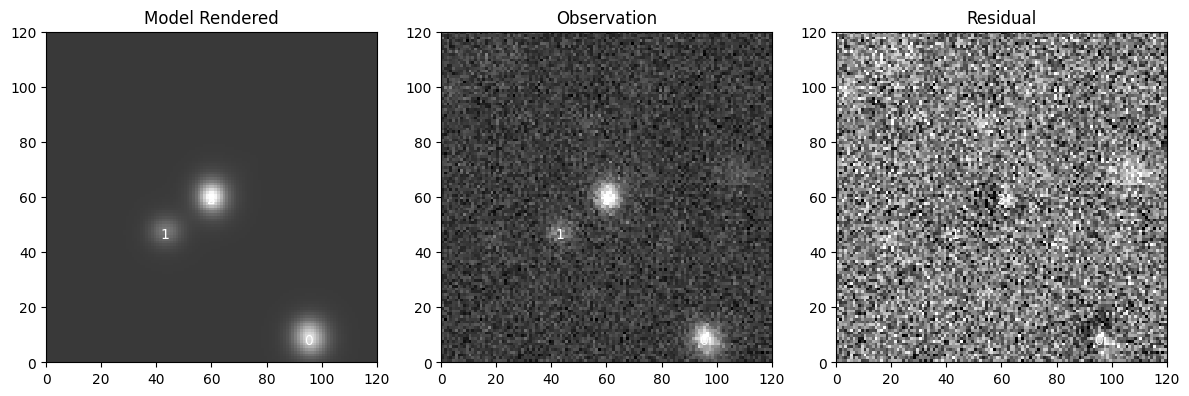

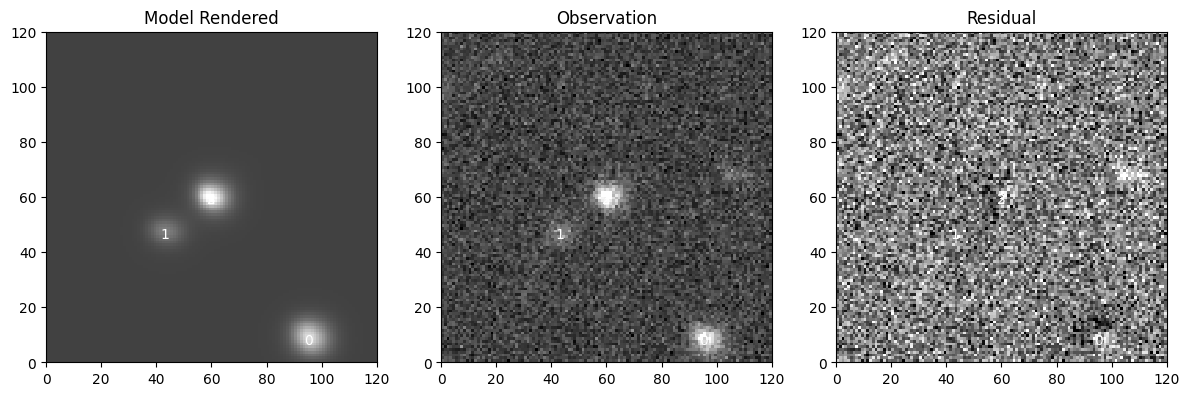

In [17]:
scarlet.initialization.set_spectra_to_match(sources, observations)
#Make the scarlet1 blend
blend = scarlet.Blend(sources, observations)

#Plot the initial guess for the first 2 observations
for i in range(len(observations[:2])):
    print(observations[i].channels)
    scarlet.display.show_scene(sources,
                               norm=normsingle[i],
                               observation=observations[i],
                                show_model=False,
                               show_rendered=True,
                               show_observed=True,
                               show_residual=True,
                               figsize=(12,4)
                              )

Fit the sources with scarlet1 and show the likelihood vs the iterations. We can skip this step if we want scarlet2 to do all the fitting work, but we'll leave it here for now so we can compare scarlet1 and scarlet2 fitting results.

scarlet ran for 22 iterations to logL = 315294.0368866398


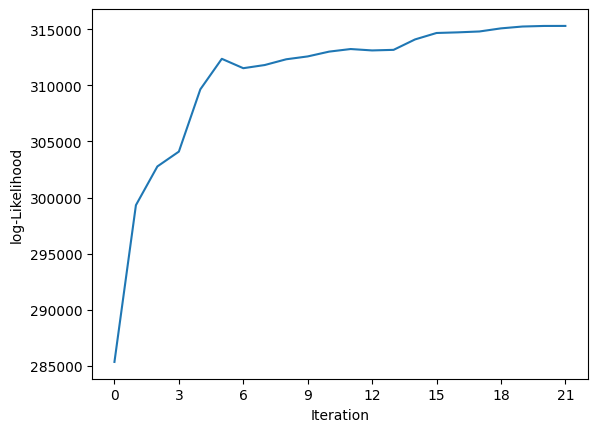

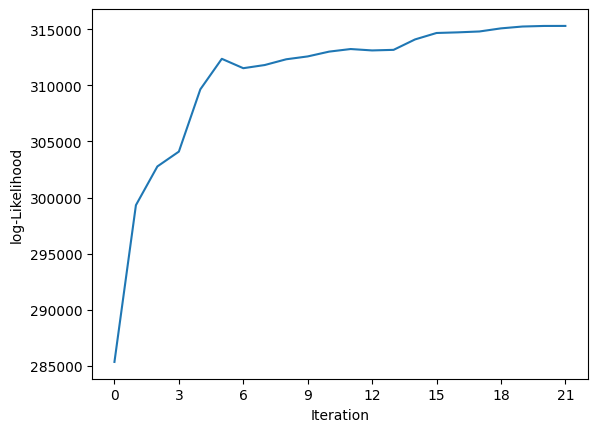

In [18]:
it, logL = blend.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)


Show the scarlet1 fitting results for the first few images. 

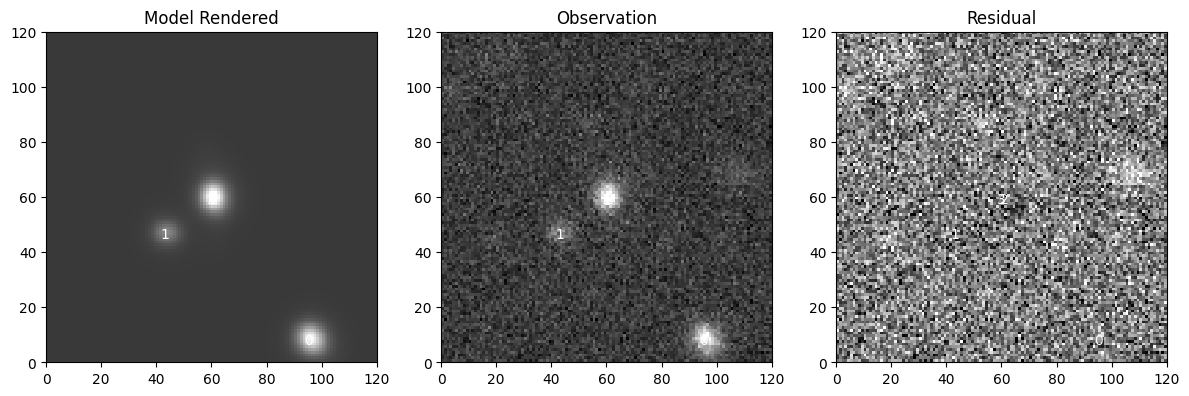

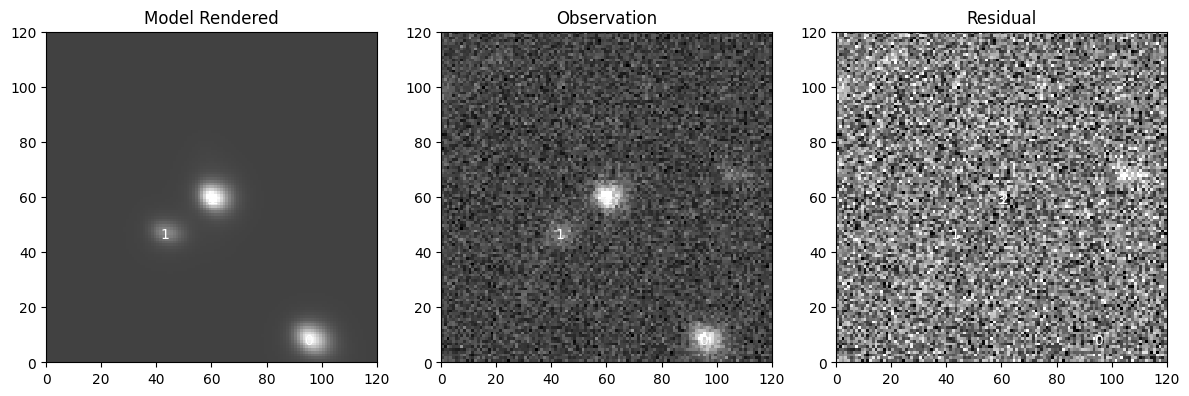

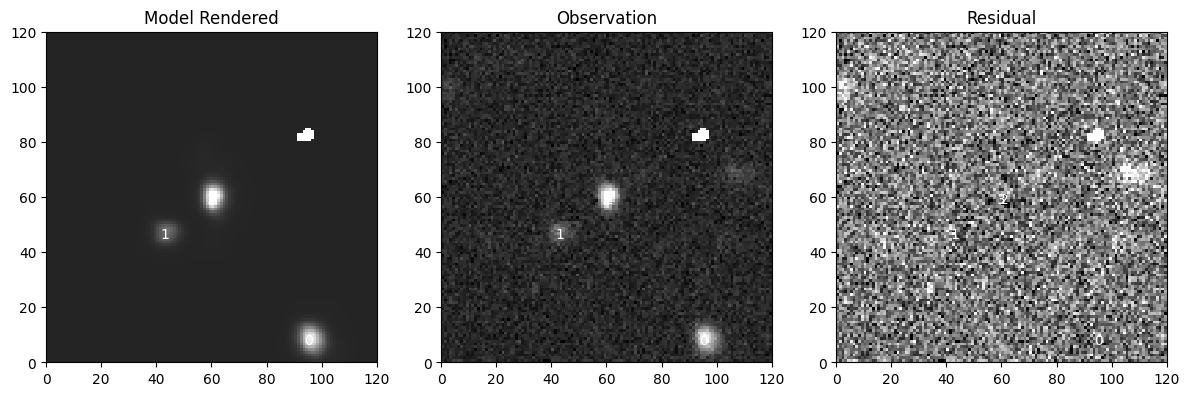

In [19]:
for i in range(len(observations[:3])):
    scarlet.display.show_scene(sources,
                               norm=normsingle[i],
                               observation=observations[i],
                               show_model=False,
                               show_rendered=True,
                               show_observed=True,
                               show_residual=True,
                               figsize=(12,4)
                              )


Define the scarlet2 PSF model and model frame. Match the model frame to the observations.

In [20]:
frame_psf_sc2 = scarlet2.GaussianPSF(0.7)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),observations_sc2[0].data.shape[-2],observations_sc2[0].data.shape[-1])), psf=frame_psf_sc2, channels=channels_sc2)
box_sizes = [s.morphology.bbox.shape for s in sources]
for obs in observations_sc2:
    obs.match(model_frame_sc2)

Initialize the scarlet2 morphologies based on scarlet1:

In [21]:
morph_init = [None]*(len(sources))
for i,s in enumerate(sources):
    raw = s.morphology.get_model()
    raw[raw<=0] = 1e-10
    morph_init[i] = (raw)/(jnp.max(raw)-jnp.min(raw))#1e-10 #I am using the positive constraint on the morphology so need to have values>0 in the morphology array
    #morph_init[i][morph_init[i]<=0] = 1e-10

Initialize scarlet2 sources using morphologies and fluxes from scarlet1

In [16]:
from scarlet2 import nn
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,src in enumerate(sources):      
        #Use the prior trained on HSC galaxies
        prior = scarlet2.nn.NNPrior(trained_model='hsc', log_space=False,shape=jnp.shape(morph_init[i]))# hsc, ZTF
        #Define a point source at the transient location
        if i==indtransient:
            bboxpos = src.morphology.bbox.center
            diff = src.center - list(bboxpos)[1:2]
            pos = np.asfarray([src.center[0]-offset[0],src.center[1]-offset[1]])
            flux = src.spectrum.get_model()
            flux[flux<0] = 1e-10
            scarlet2.PointSource(
                    pos,
                    scarlet2.ArraySpectrum(Parameter(jnp.asarray(flux), stepsize=1e-2*flux, constraint=constraints.positive)))
       
        else:
            #Define a generic, non-variable galaxy where all other sources are detected
            pos = np.asfarray([src.morphology.bbox.center[0]-offset[0],src.morphology.bbox.center[1]-offset[1]])
            flux = src.spectrum.get_model()[indices]
            flux[flux<0] = 1e-10
            #For a non-static generic source you would do this instead
            #scarlet2.Source(
            #    pos,
            #    scarlet2.ArraySpectrum(Parameter(jnp.asarray(flux), stepsize=1e-2*flux)),scarlet2.ArrayMorphology(Parameter(morph_init[i], stepsize=1e-2, prior=prior)))

            scarlet2.Source(
                pos,
                scarlet2.StaticArraySpectrum(Parameter(jnp.asarray(flux), stepsize=1e-2*flux,constraint=constraints.positive),filters=bandall),scarlet2.ArrayMorphology(Parameter(morph_init[i], stepsize=1e-2, constraint=constraints.positive, prior=prior)))
            
        

Plot scarlet2 initializations

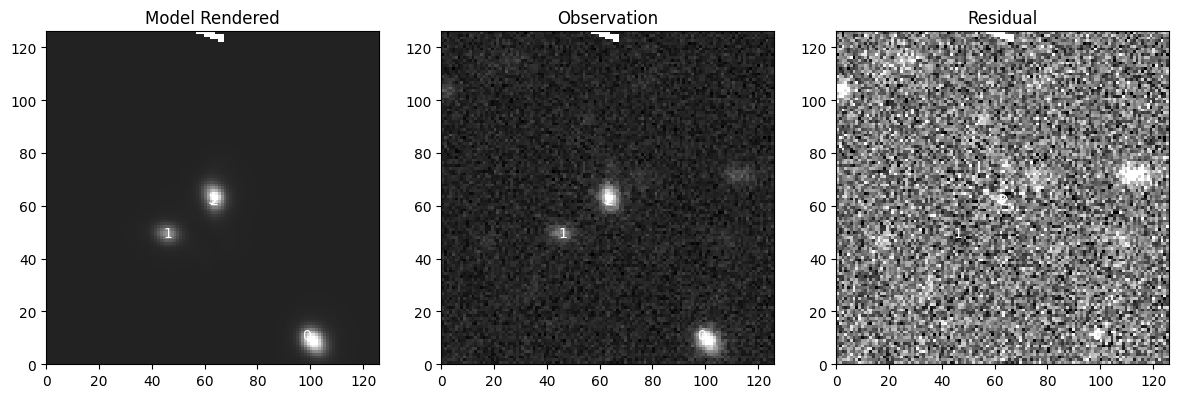

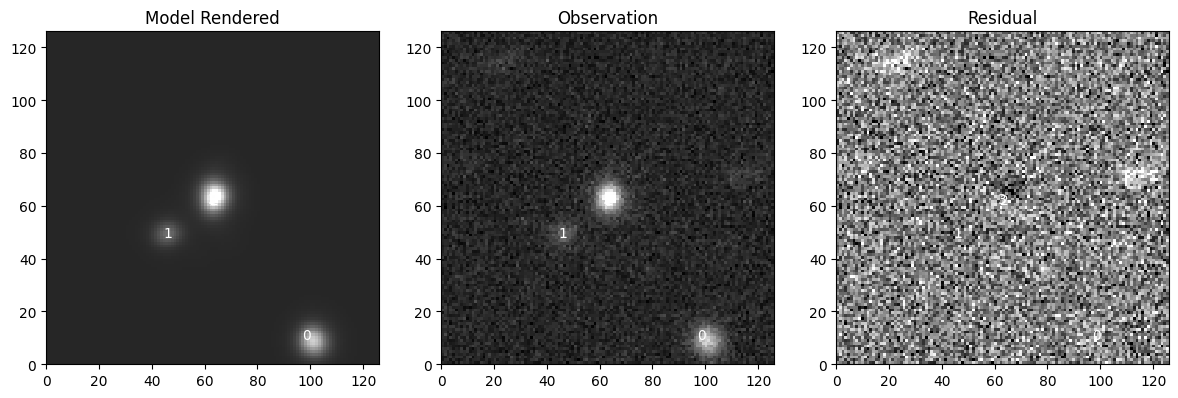

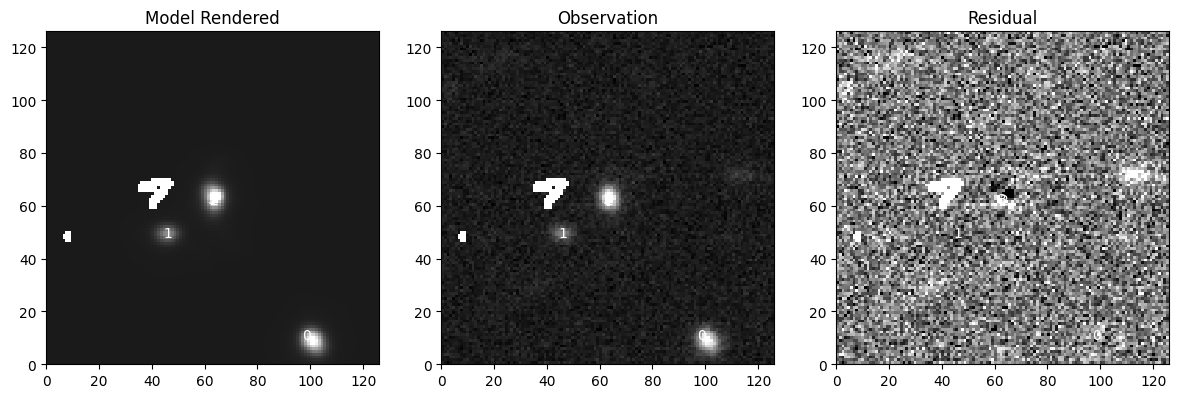

In [17]:
#Plot initialization for first epoch of each band
channels = np.asarray(channels)
observations_sc2_arr = np.asarray(observations_sc2)
normsinglearr = np.asarray(normsingle)
for i,(chan,obs,obs1,norm) in enumerate(zip(channels[indices],observations_sc2_arr[indices],observations,normsinglearr[indices])):
        model_ = obs.render(scene())
        scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           #channel_map = obs.renderer.channel_map,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, coverage='intersection', model_psf=model_psf)[0],#model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )

In [18]:
#Free up the position parameter of the variable point source before fitting the scene
scene.set_info('sources.'+str(indtransient)+'.morphology.center', fixed=False)
scene_ = scene.fit(observations_sc2, max_iter=1000, e_rel=1e-6)



100%|██████████| 1000/1000 [00:39<00:00, 25.18it/s, loss=-274668.03]


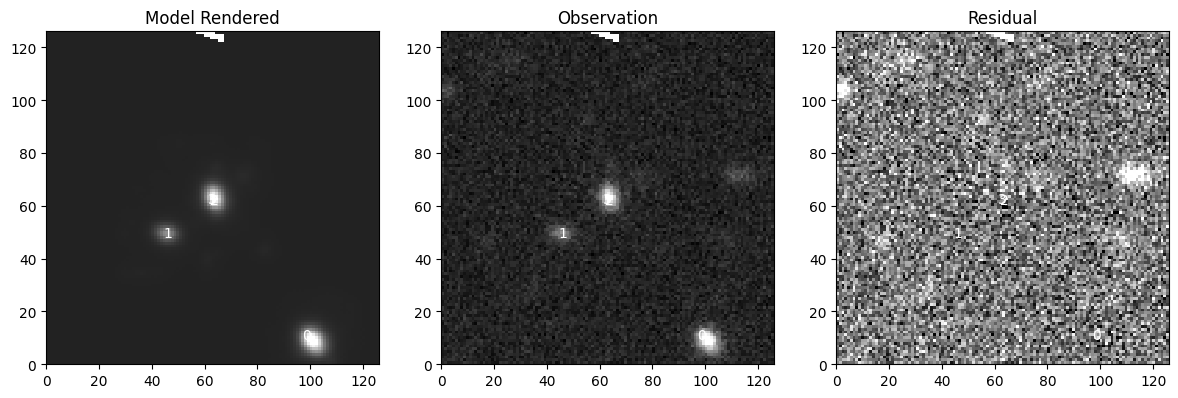

<Figure size 640x480 with 0 Axes>

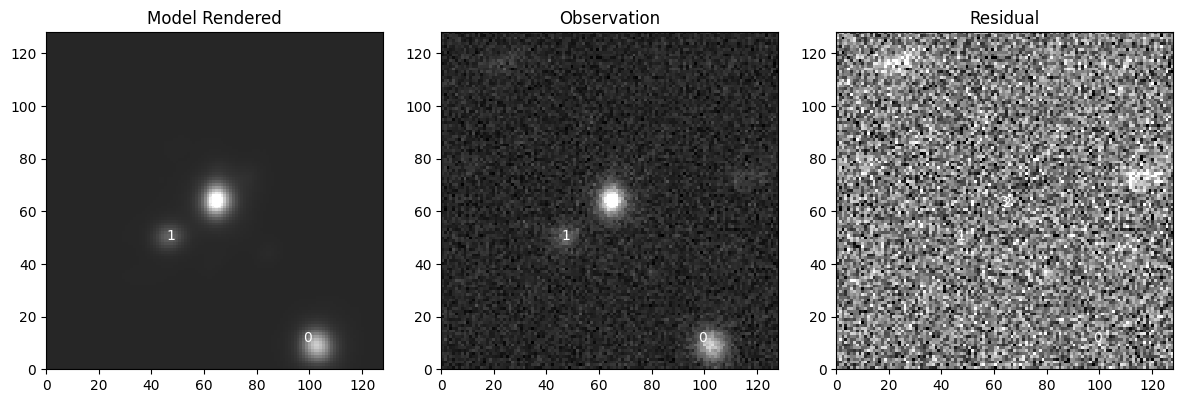

<Figure size 640x480 with 0 Axes>

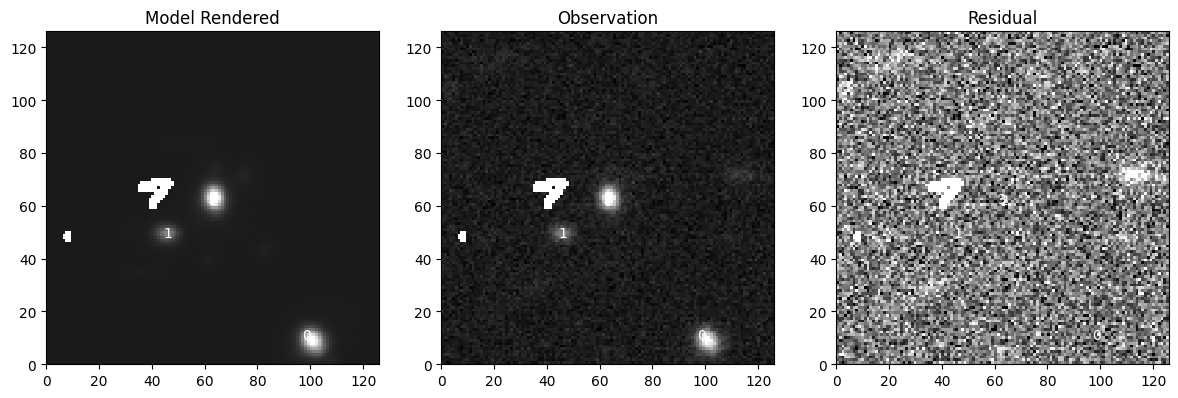

<Figure size 640x480 with 0 Axes>

In [19]:
#Plot final model for first image in each band
for i,(chan,obs,obs1,norm) in enumerate(zip(channels[indices],observations_sc2_arr[indices],obssinglearr[indices],normsinglearr[indices])):
        model_ = obs.render(scene_())
        scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, coverage='intersection', model_psf=model_psf)[0],
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )
        plt.savefig(plotdir+'/scarlet2fit'+chan+'.png')
        plt.show()
        plt.clf()

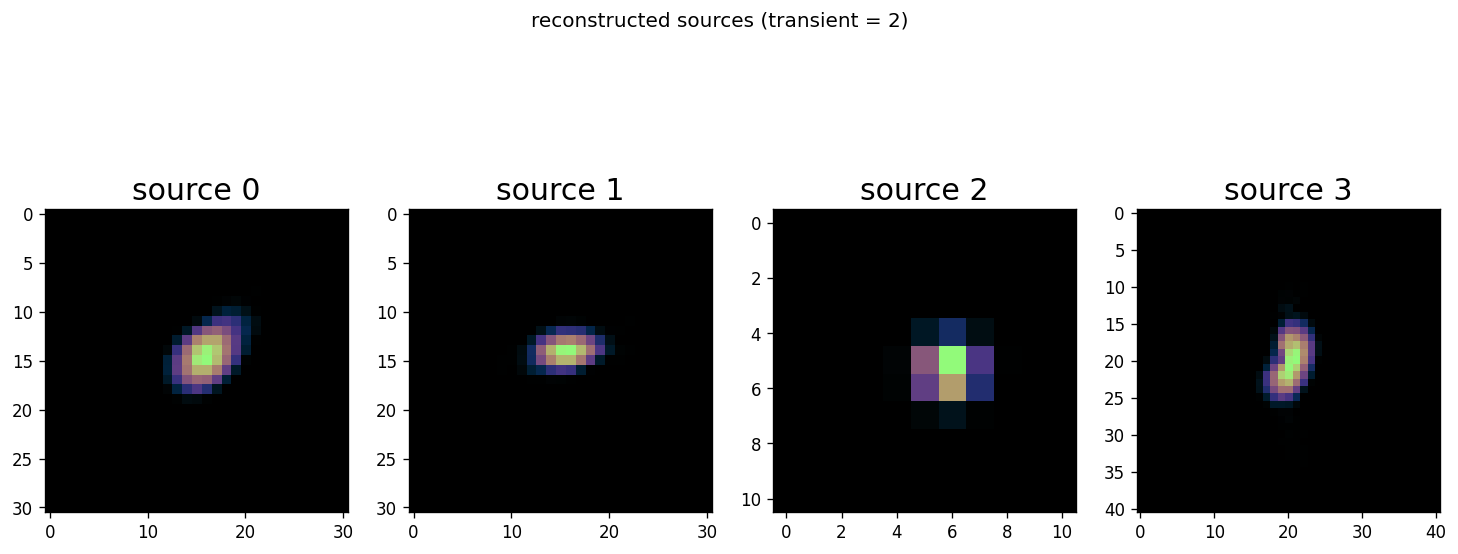

<Figure size 640x480 with 0 Axes>

In [20]:
#Plot zoom-ins on the individual sources - rescale as desired
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene.sources[i].morphology()
    else:
        y = scene.sources[i].morphology.data
    ax.imshow(y, cmap = cmap,interpolation=int_method)
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.show()
plt.clf()

sample: 100%|██████████| 1500/1500 [01:37<00:00, 15.46it/s, 3 steps of size 8.54e-01. acc. prob=0.92] 


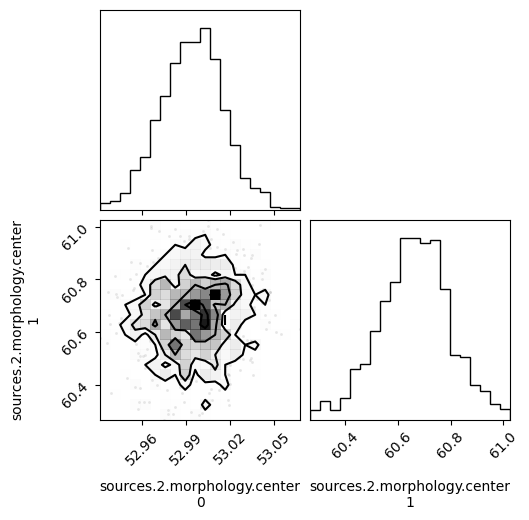

<Figure size 640x480 with 0 Axes>

In [21]:
#Example for sampling over point source position (in pixel space)
scene_.set_info(scene_.parameters.keys(), fixed=True) 
scene_.set_info('sources.'+str(indtransient)+'.morphology.center', fixed=False, prior=dist.Normal(scene_.sources[indtransient].morphology.center, 0.5))
mcmc = scene_.sample(observations_sc2) 
q = mcmc.get_samples()['sources.'+str(indtransient)+'.morphology.center'] 
q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
corner.corner(mcmc).show() 
plt.show()
plt.clf()


[2.6563001e+00 7.6105523e+00 1.0205431e+01 4.2440095e+00 2.2515250e-02
 3.5941349e+01 2.7745962e+01 2.5505114e+01 3.2986828e+01 4.0695068e+01
 3.2568832e+01 4.1694096e+01 1.5257391e+01 9.3579569e+00 1.0653377e+01
 8.9564695e+00 9.1488209e+00 1.2708150e+01 2.4673557e+01 2.0261820e+01]


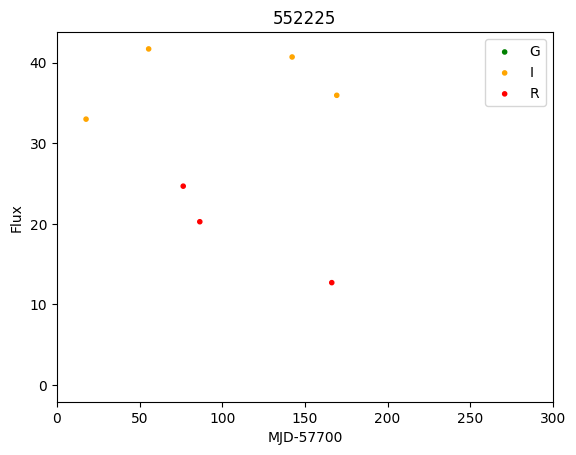

In [22]:
#Example for extracting simple light curve from the scarlet2 fits
fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
times=np.asarray(times)
flux = scene_.sources[indtransient].spectrum.data
print(flux)
for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
    plt.scatter(times[bands_individual==b]-57700,flux[bands_individual==b],linestyle='',label=b,color=c,marker='.')
plt.xlabel('MJD-57700')
plt.xlim((0,300))
plt.ylabel('Flux')
plt.legend()
plt.title(srcname)
plt.savefig(plotdir+'/'+srcname+'_lc_flux.png')
plt.show()

In [23]:
#Example for using sampler to get errors on flux values and use them as errorbars in a light curve
makelc = False
if makelc:
    scene_.set_info(scene_.parameters.keys(), fixed=True)
    scene_.set_info('sources.'+str(indtransient)+'.spectrum.data', fixed=False, prior=dist.Normal(scene_.sources[indtransient].spectrum.data, 0.01*scene_.sources[indtransient].spectrum.data))#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))##01*scene.sources[5].spectrum.data))#dist.Uniform(scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2))
    mcmc = scene_.sample(observations_sc2)
    q = mcmc.get_samples()['sources.'+str(indtransient)+'.spectrum.data']
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0)
    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
    fluxes = []
    fluxerrors = []
    for i,b in zip(range(q1.shape[1]),bandind):
        print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2)
        fluxes.append(q1[2][i]*fac)
        fluxerrors.append((q1[3][i]-q1[1][i])/2*fac)
    
    mcmc.print_summary()
    corner.corner(mcmc).show()
    plt.clf()
    
    for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
        plt.errorbar(times[bands_individual==b]-57700,fluxes[bands_individual==b],yerr = fluxerrors[bands_individual==b],linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    plt.xlabel('MJD-57700')
    plt.xlim((0,300))
    #plt.ylim((22.0,22.3))
    plt.ylabel('Flux')
    plt.legend()
    plt.title(srcname)
    plt.show()

warmup:  14%|█▍        | 210/1500 [02:36<16:02,  1.34it/s, 127 steps of size 1.67e-02. acc. prob=0.77]   


KeyboardInterrupt: 

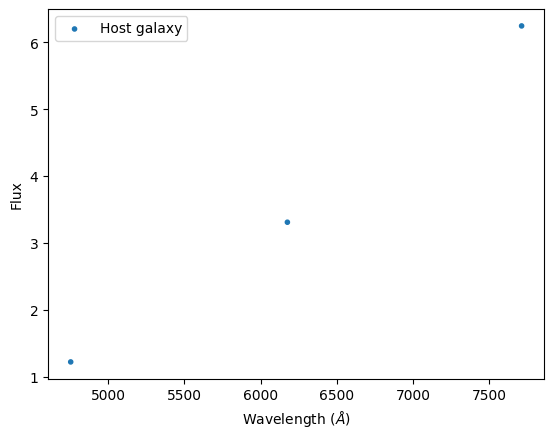

[[1.2211142 6.2542205 3.3038032]
 [1.2110039 6.23139   3.296257 ]
 [1.2216021 6.2378387 3.3031833]
 ...
 [1.2148745 6.26139   3.311407 ]
 [1.2161337 6.2534137 3.3164132]
 [1.2190628 6.2409515 3.309048 ]]
0 median =  1.218382716178894 std =  0.00670061349868778
1 median =  6.246107339859009 std =  0.015813312530517543
2 median =  3.308483600616455 std =  0.00885676383972167

                                mean       std    median      5.0%     95.0%     n_eff     r_hat
sources.3.spectrum.data[0]      1.22      0.01      1.22      1.21      1.23   1250.15      1.00
sources.3.spectrum.data[1]      6.25      0.02      6.25      6.22      6.27    636.07      1.00
sources.3.spectrum.data[2]      3.31      0.01      3.31      3.30      3.32    974.18      1.00

Number of divergences: 0


<Figure size 640x480 with 0 Axes>

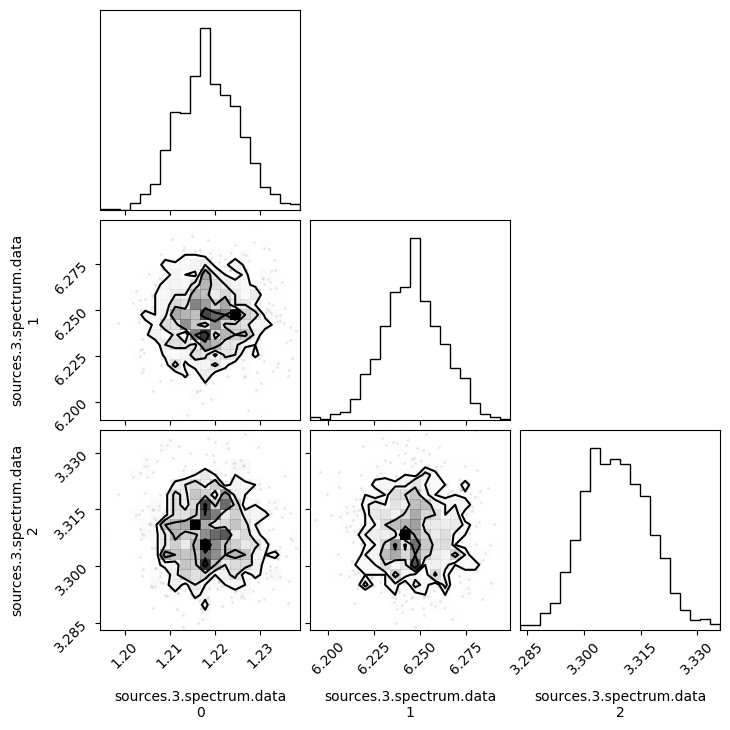

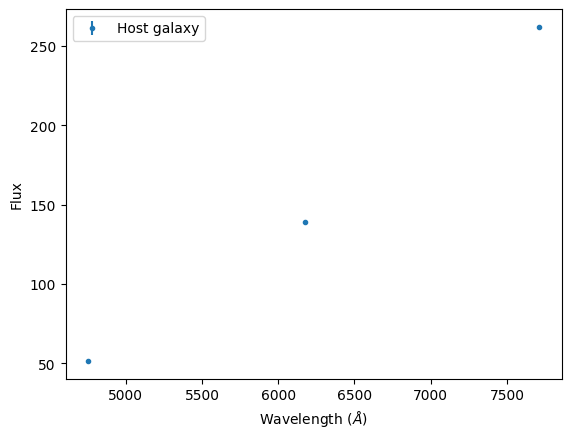

NameError: name 'sed' is not defined

<Figure size 640x480 with 0 Axes>

In [29]:
#Example for sampling over static source flux parameters to get SED with errorbars for the host galaxy
getgalaxySED=True
if getgalaxySED==True:
    wave = [4754,7711,6175]#,9762,8898]
    out = np.column_stack((wave,scene_.sources[indtransient+1].spectrum.data))
    np.savetxt(plotdir+'/sed_quick.txt',np.asarray(out,dtype=str),fmt='%s')
    plt.scatter(wave,scene_.sources[indtransient+1].spectrum.data,marker='.',linestyle='',label='Host galaxy')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_SED_GAL_quick.png')
    plt.show()
    plt.clf()
    scene_.set_info(scene_.parameters.keys(), fixed=True)
    scene_.set_info('sources.'+str(indtransient+1)+'.spectrum.data', fixed=False, prior=dist.Normal(np.clip(scene_.sources[indtransient+1].spectrum.data,a_min=1e-5,a_max=1e6), 0.01*np.clip(scene_.sources[indtransient+1].spectrum.data,a_min=1e-5,a_max=1e6)))#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))##01*scene.sources[5].spectrum.data))#dist.Uniform(scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2))
    mcmc = scene_.sample(observations_sc2)#,num_warmup=20, num_samples=20)
    q = mcmc.get_samples()['sources.'+str(indtransient+1)+'.spectrum.data']
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0)
    fac = np.sum(scene_.sources[indtransient+1].morphology.data,axis=(-2,-1))
    galfluxes = []
    galfluxerrors = []
    for i,b in zip(range(q1.shape[1]),bandind):
        print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2)
        galfluxes.append(q1[2][i]*fac)
        galfluxerrors.append((q1[3][i]-q1[1][i])/2*fac)
    mcmc.print_summary()

    corner.corner(mcmc).show()
    plt.savefig(plotdir+'/'+srcname+'_galflux_corner.png')
    plt.show()
    plt.clf()
    sedgal = np.asfarray(galfluxes)
    sedgalerr = np.asfarray(galfluxerrors)
    
    #Mags should be equal to 2.5*np.log10(63095734448.01944/sedgal))
    plt.errorbar(wave,sedgal,yerr=sedgalerr,marker='.',linestyle='',label='Host galaxy')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.legend()
    plt.show()
    plt.clf()
    outsedhead=['WAVE_CEN','AGNFLUX','AGNFLUXERR','GALFLUX','GALFLUXERR']
    outsed=np.column_stack((wave,sed,sederr,sedgal,sedgalerr))
    outsed = np.vstack((outsedhead,outsed))
    np.savetxt(plotdir+'/sed.txt',np.asarray(outlc,dtype=str),fmt='%s')